# Case 1: User KGI 04

## Import Dependencies

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import optuna
import joblib
from sklearn.pipeline import Pipeline

## Data Loading

In [2]:
PATH = './Dataset/unconv_MV.csv'

df = pd.read_csv(PATH)

## Simple Data Exploration

In [3]:
print("\n--- Data Exploration ---")
print(f"Dataset Shape: {df.shape}")
print("First 5 rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())


--- Data Exploration ---
Dataset Shape: (1000, 8)
First 5 rows:
   WellIndex    Por  LogPerm    AI  Brittle   TOC    VR   Production
0          1  15.91     1.67  3.06    14.05  1.36  1.85   177.381958
1          2  15.34     1.65  2.60    31.88  1.37  1.79  1479.767778
2          3  20.45     2.02  3.13    63.67  1.79  2.53  4421.221583
3          4  11.95     1.14  3.90    58.81  0.40  2.03  1488.317629
4          5  19.53     1.83  2.57    43.75  1.40  2.11  5261.094919

Basic Statistics:
         WellIndex          Por      LogPerm           AI      Brittle  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    500.500000    14.950460     1.398880     2.982610    49.719480   
std     288.819436     3.029634     0.405966     0.577629    15.077006   
min       1.000000     5.400000     0.120000     0.960000   -10.500000   
25%     250.750000    12.857500     1.130000     2.577500    39.722500   
50%     500.500000    14.985000     1.390000     3.010000 

## Data Visualization


--- Data Visualization ---
Creating visualizations...


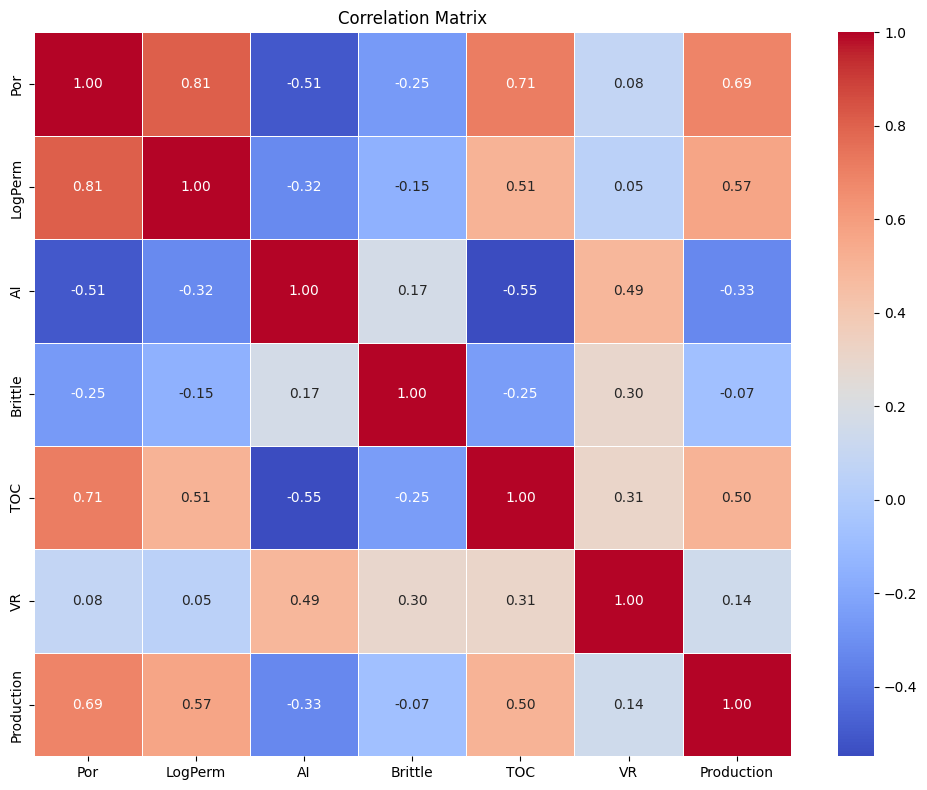

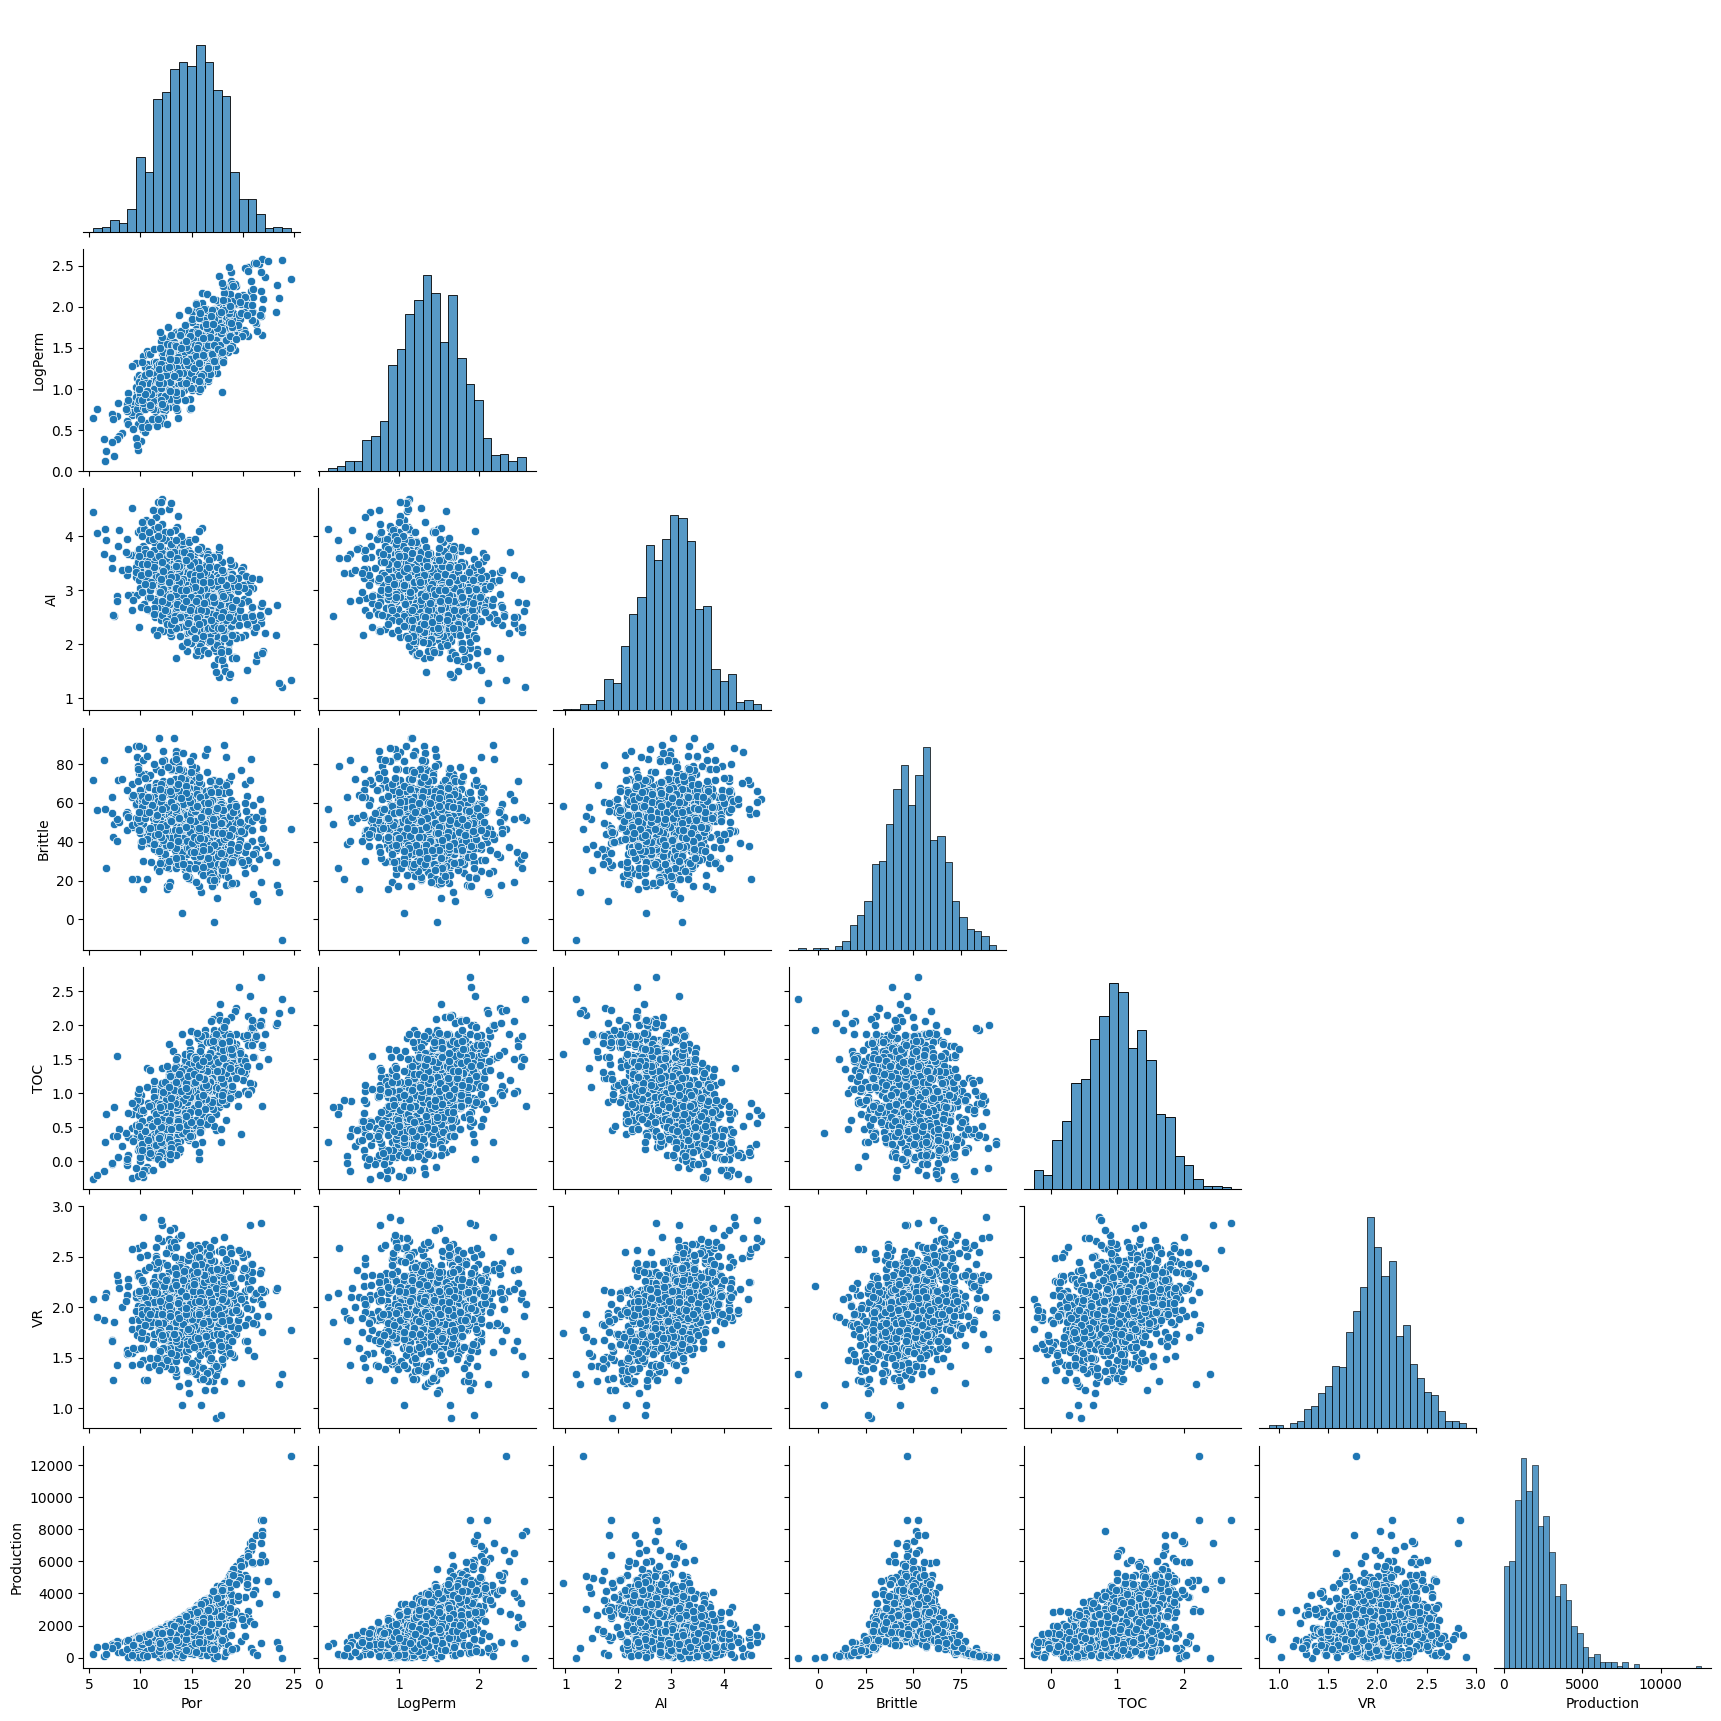

In [4]:
print("\n--- Data Visualization ---")
print("Creating visualizations...")

corr_matrix = df.drop('WellIndex',axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

pairplot_features = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR', 'Production']

sns.pairplot(df[pairplot_features], corner=True)
plt.savefig('pairplot.png')
plt.show()

The correlation heatmap (Image 1) shows strong positive correlations between Production and key features like Porosity (Por, 0.69), Log Permeability (LogPerm, 0.57), and Total Organic Carbon (TOC, 0.50), while Acoustic Impedance (AI) shows a moderate negative correlation (-0.33) with Production. The pairplot (Image 2) further confirms these relationships, displaying clear positive trends between Por-LogPerm, Por-TOC, and Por-Production, with a particularly strong exponential-like relationship between Porosity and Production. These visualizations highlight that reservoir productivity is most strongly influenced by porosity, permeability, and organic content, providing valuable insights for model development in predicting production volumes.

## Data Preprocessing

In [5]:
print("\n--- Data Preprocessing ---")

def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

for column in df.columns:
    if column not in ['WellIndex', 'Production']:
        outliers = detect_outliers(df, column)
        print(f"Outliers in {column}: {len(outliers)}")

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

for column in df.columns:
    if column not in ['WellIndex']:
        df = handle_outliers(df, column)

print("Outliers handled using capping")

X = df.drop(['WellIndex', 'Production'], axis=1)
y = df['Production']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


--- Data Preprocessing ---
Outliers in Por: 6
Outliers in LogPerm: 10
Outliers in AI: 10
Outliers in Brittle: 9
Outliers in TOC: 2
Outliers in VR: 19
Outliers handled using capping
Train set: (800, 6), Test set: (200, 6)


## Model Building and Training

In [6]:
print("\n--- Model Building and Training ---")

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Train R²: {train_r2:.2f}")
    print(f"Test R²: {test_r2:.2f}")
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    cv_rmse = cross_val_score(model, X, y, cv=5, scoring=make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False))
    
    print(f"Cross-Validation R² Scores: {cv_r2}")
    print(f"Mean CV R²: {cv_r2.mean():.2f}")
    print(f"Mean CV MAE: {-cv_mae.mean():.2f}")
    print(f"Mean CV RMSE: {-cv_rmse.mean():.2f}")
    
    return model, y_test_pred

print("\nLinear Regression:")
lr_model = LinearRegression()
lr_model, lr_pred = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nRandom Forest:")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model, rf_pred = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nXGBoost:")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model, xgb_pred = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)


--- Model Building and Training ---

Linear Regression:
Train RMSE: 979.97
Test RMSE: 948.87
Train R²: 0.48
Test R²: 0.50
Train MAE: 760.33
Test MAE: 758.88
Cross-Validation R² Scores: [0.47260813 0.43419677 0.49129053 0.45129509 0.50939397]
Mean CV R²: 0.47
Mean CV MAE: 768.99
Mean CV RMSE: 985.57

Random Forest:
Train RMSE: 61.85
Test RMSE: 158.74
Train R²: 1.00
Test R²: 0.99
Train MAE: 36.66
Test MAE: 86.83
Cross-Validation R² Scores: [0.98532791 0.98319292 0.98808755 0.98093343 0.9899572 ]
Mean CV R²: 0.99
Mean CV MAE: 96.29
Mean CV RMSE: 162.29

XGBoost:
Train RMSE: 19.37
Test RMSE: 122.37
Train R²: 1.00
Test R²: 0.99
Train MAE: 14.14
Test MAE: 72.75
Cross-Validation R² Scores: [0.97805869 0.98660404 0.99355265 0.98150617 0.99239487]
Mean CV R²: 0.99
Mean CV MAE: 84.60
Mean CV RMSE: 153.72


The model building and training results demonstrate significant performance differences between the tested algorithms. Linear Regression showed modest performance with a test RMSE of 948.87 and R² of 0.50, indicating it captures only half of the production variance and struggles with the likely non-linear relationships in the data. In contrast, both tree-based ensemble methods delivered exceptional performance, with Random Forest achieving a test RMSE of 158.74 and R² of 0.99, while XGBoost performed slightly better on training (RMSE 19.37 vs 61.85) and similarly on testing (RMSE 122.37, R² 0.99). Cross-validation confirmed the robustness of these models across different data subsets, with mean CV R² values of 0.99 for both ensemble methods. The substantial gap between Linear Regression and tree-based models suggests strong non-linear relationships between reservoir properties and production, which the ensemble methods successfully capture, making XGBoost or Random Forest the clear choices for production prediction.

## Hyperparameter Tuning with Bayesian Optimization

In [7]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42
    }
    
    model = XGBRegressor(**params)
    neg_mse = cross_val_score(
        model, X, y,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )
    return -neg_mse.mean()

print("\n--- Hyperparameter Tuning with Optuna ---")

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"Best parameters: {study.best_params}")
print(f"Best CV RMSE: {np.sqrt(study.best_value):.2f}")

best_xgb = XGBRegressor(**study.best_params)
best_xgb.fit(X_train_scaled, y_train)
best_pred = best_xgb.predict(X_test_scaled)
best_rmse = np.sqrt(mean_squared_error(y_test, best_pred))
best_r2 = r2_score(y_test, best_pred)

print(f"Best Model RMSE on Test Set: {best_rmse:.2f}")
print(f"Best Model R² on Test Set: {best_r2:.2f}")

[I 2025-04-26 19:41:30,104] A new study created in memory with name: no-name-c346fe6c-0533-41e1-ac2a-2bd87d30da9d



--- Hyperparameter Tuning with Optuna ---


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-26 19:42:48,324] Trial 0 finished with value: 17239.405172889627 and parameters: {'learning_rate': 0.02689875659190978, 'max_depth': 5, 'n_estimators': 292, 'subsample': 0.6950214178220502}. Best is trial 0 with value: 17239.405172889627.
[I 2025-04-26 19:42:51,542] Trial 1 finished with value: 29564.886927416315 and parameters: {'learning_rate': 0.2778517529139133, 'max_depth': 9, 'n_estimators': 64, 'subsample': 0.9641366160910765}. Best is trial 0 with value: 17239.405172889627.
[I 2025-04-26 19:42:52,607] Trial 2 finished with value: 16832.854648186396 and parameters: {'learning_rate': 0.04438989511664914, 'max_depth': 8, 'n_estimators': 260, 'subsample': 0.6943309072858161}. Best is trial 2 with value: 16832.854648186396.
[I 2025-04-26 19:42:53,147] Trial 3 finished with value: 23249.774003942686 and parameters: {'learning_rate': 0.03834906053630008, 'max_depth': 6, 'n_estimators': 243, 'subsample': 0.9425905160842138}. Best is trial 2 with value: 16832.854648186396.
[I

From the previous section, we know that XGBoost is the best out of the models experimented. Hence, hyperparameter tuning is done to make sure that the model performance stay stable and can generalize to new data. The hyperparameter tuning successfully decrease the RMSE on test set which is previously 153.72 to 107.98 indicating that the hyperparameter tuning succeeds.

## Model Evaluation Visualization


--- Model Evaluation and Visualization ---


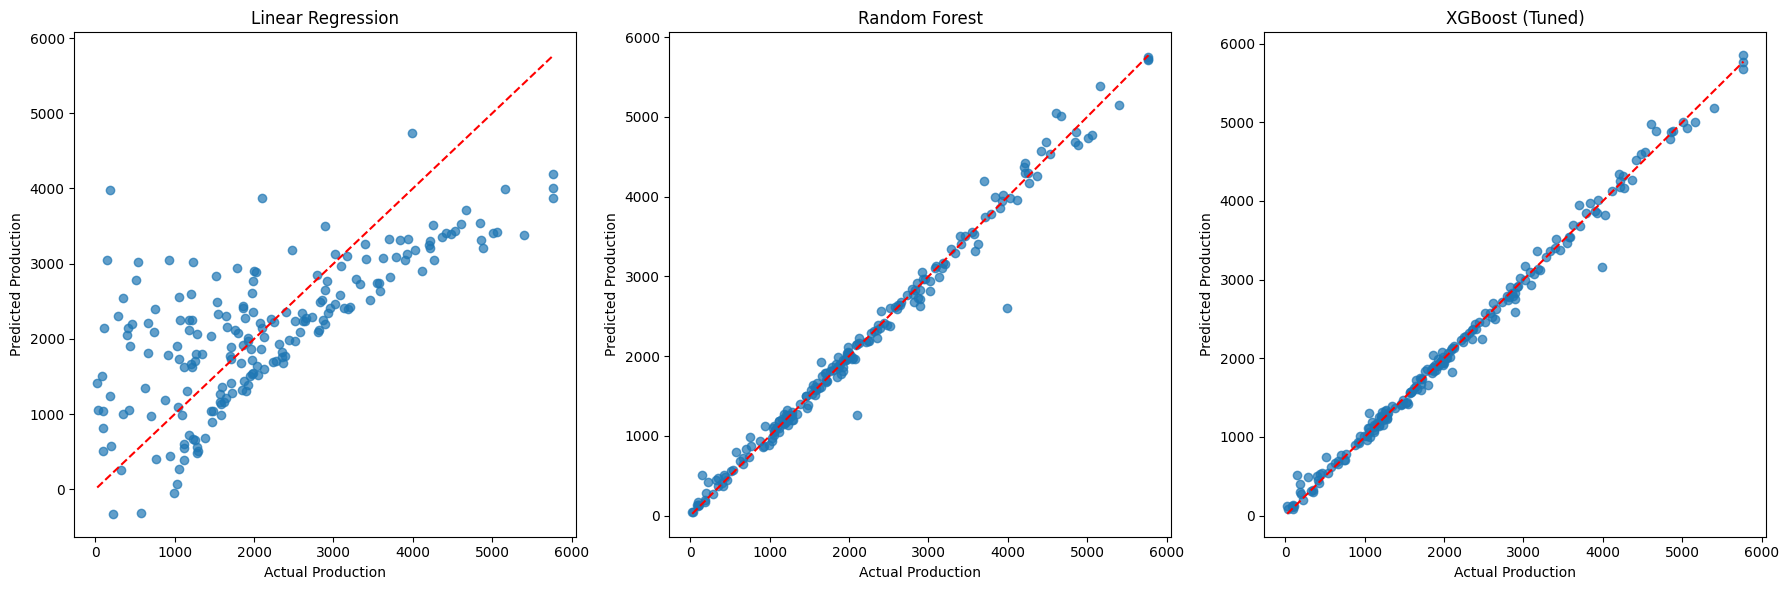

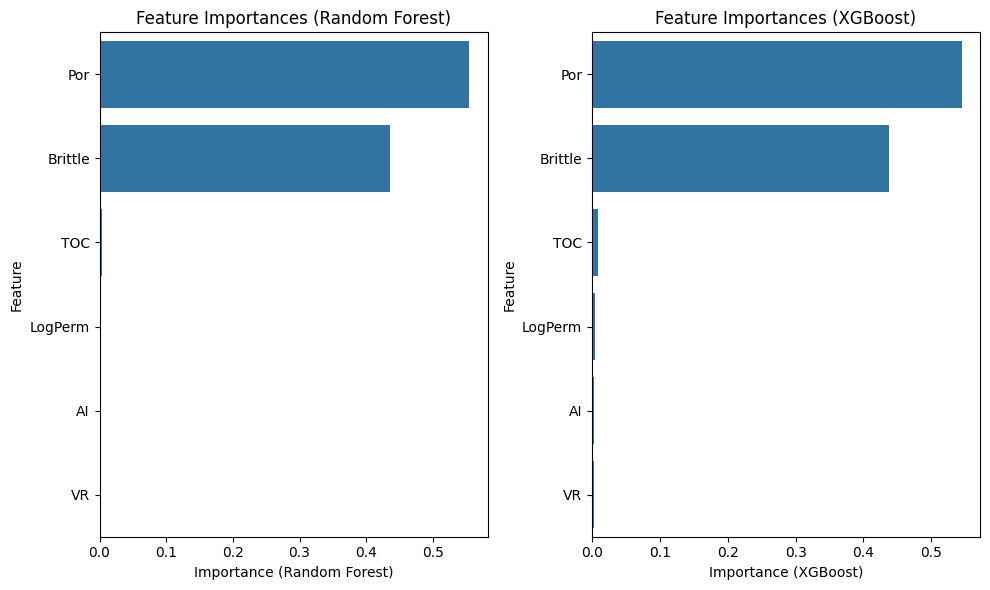

In [8]:
print("\n--- Model Evaluation and Visualization ---")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test, lr_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Linear Regression')

plt.subplot(1, 3, 2)
plt.scatter(y_test, rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Random Forest')

plt.subplot(1, 3, 3)
plt.scatter(y_test, best_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('XGBoost (Tuned)')

plt.tight_layout()
plt.savefig('model_predictions.png')

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance (Random Forest)': rf_model.feature_importances_,
    'Importance (XGBoost)': best_xgb.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance (Random Forest)', ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(x='Importance (Random Forest)', y='Feature', data=feature_importance)
plt.title('Feature Importances (Random Forest)')

plt.subplot(1, 2, 2)
sns.barplot(x='Importance (XGBoost)', y='Feature', data=feature_importance)
plt.title('Feature Importances (XGBoost)')

plt.tight_layout()
plt.savefig('feature_importance.png')

From Image 1, we can see that Linear Regression's predictions are poor, casuing the predictions to fall far away from the true label. Random Forest shows great performance, most of the predictions are spot on, but there are still few predictions that are quite far off. On the other hand, XGBoost showcases exquisite predictive power, the predictions are mostly accurate, leaving least room for errors across these three models.

From Image 2, we can conclude that, based on both of the tree models' feature importances, those are, Random Forest and XGBoost, it is known that the most influential features that contributed to the models decision making is Por and Brittle coming in second. This aligns with the visualization interpretation that was made earlier.

## Residual Analysis

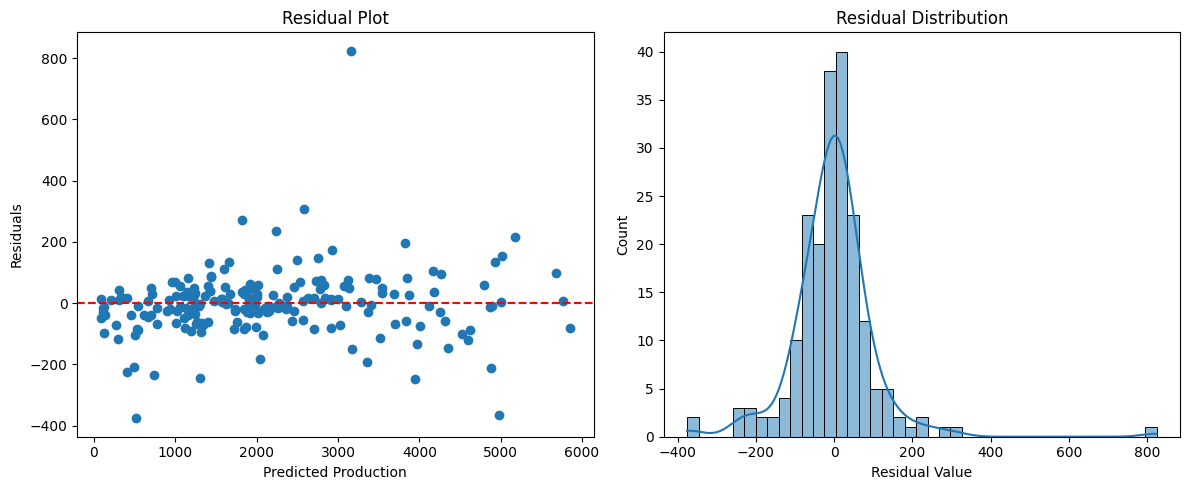

In [9]:
plt.figure(figsize=(12, 5))

residuals = y_test - best_pred

plt.subplot(1, 2, 1)
plt.scatter(best_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Production')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residual Value')
plt.title('Residual Distribution')

plt.tight_layout()
plt.savefig('residual_analysis.png')

The residual plot analysis for the best model shows a generally well-performing prediction system with several key characteristics. The left plot reveals residuals clustered around zero, indicating good overall accuracy, though there's a slight pattern where higher predicted production values (above 2000) show more positive residuals, suggesting potential underprediction for high-producing wells. One notable outlier with a residual of approximately 800 indicates a substantial miss for a specific well sample. The right histogram confirms that residuals follow a nearly normal distribution centered at zero, with most errors falling within ±200 units, supporting the model's validity. This residual analysis suggests the model performs well across most production ranges but might benefit from further refinement to better capture extreme high-production cases.

## Final Model Saving

In [10]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_xgb)
])

# Fit on entire dataset
final_pipeline.fit(X, y)

joblib.dump(final_pipeline, 'reservoir_production_model.pkl')
print("Final model pipeline created and ready for deployment")

Final model pipeline created and ready for deployment
